In [1]:
## call the main routines
using NBInclude
@nbinclude("core_fun.ipynb");

We fix the parameters for the case of Austria in an object of type Country. The calibrated values for $\alpha$ and $m$ are obtained latter on.

In [2]:
austria = let 
    
    reform = 2
    A = 50. * 12
    Amin = 46. * 12
    Amax = 54. * 12
    
    r = 0.0048 # 5 % annual interest rate, time unit = month
    c0 = 1. # scale parameter of the cost function, normalized to 1
    q = 0.02 ## 1-exp(-12q) should be close to 0.22~0.25
    lambdamax = 1/(39*12/52) ## 39 weeks eligibility
    lambdamin = 1/(209*12/52) ## 209 weeks

    ### to be updated after the calibration
    alpha, m = 0.02 , 0.07
    
    uinit = [0.,0.] ## useless parameters
    
    wbar = 1. # normalization
    bUI = 0.6 * wbar  # replacement rate for median wage earner, Lalive
    b0max = 0.7 * bUI # median UA for the median UI, Lalive
    b0min = b0max 
    
    Country(reform,A,Amin,Amax,r,c0,alpha,q,m,lambdamin,lambdamax,uinit,bUI,b0max,b0min,wbar)
end
;

In [3]:
## precompile functions
let 
    a=49.75*12
    B=6.2
    D=15.4
    simu_aus = find_simu(austria,reltol=1e-5) 
    @time fUI(B, a, simu_aus,austria) 
    @time expectedB(a, simu_aus,austria)
    @time integrand_fNE(B, D, a,simu_aus,austria)
    @time fNE(D, a, simu_aus, austria) 
    @time print(expectedD(a, simu_aus,austria))
end

  2.572422 seconds (5.86 M allocations: 295.883 MiB, 6.12% gc time)
  0.408777 seconds (1.26 M allocations: 44.626 MiB, 5.94% gc time)
  0.508925 seconds (650.83 k allocations: 32.026 MiB, 2.53% gc time)
  0.529631 seconds (1.73 M allocations: 53.003 MiB, 4.21% gc time)
3.351408892483491  9.594932 seconds (101.51 M allocations: 1.734 GiB, 4.08% gc time)


# 1) Finding $\alpha$ and $m$
We take as moments the expected duration before and after the threshold at age 50.

In [4]:
## We use the method of Simpson to compute the integral instead of the quadgk function
## because computing expectedD is already time-consuming
quadSimpson(fun,a,b) = (b-a)/6 * (fun(a) + 4*fun((a+b)/2) + fun(b)) 
function moments_austria(simu::Simu,C::Country)
    expD1 = quadSimpson(x->expectedD(x,simu,C) ,12*49.75, 12*49.99) / (12*49.99-12*49.75)
    expD2 = quadSimpson(x->expectedD(x,simu,C) ,12*50.01, 12*50.25) / (12*50.25-12*50.01)
    #expD1 = quadgk(x->expectedD(x,simu,C) ,12*49.75, 12*49.99)[1] / (12*49.99-12*49.75)
    #expD2 = quadgk(x->expectedD(x,simu,C) ,12*50.01, 12*50.25)[1] / (12*50.25-12*50.01)
    #expD1 = expectedD(49.75 *12,simu,C)
    #expD2 = expectedD(50.25 *12,simu,C)
    return([expD1, expD2])
end

moments_target = [15.2*12/52, 29.6*12/52]

function distance(m1,m2)
    out = 0
    for i in 1:length(m1)
        out += (m1[i] - m2[i]) ^2
    end
    return(out)
end

distance (generic function with 1 method)

We calibrate our model to determine the values of $\alpha$ and $m$. 

In [5]:
## generate a Country object with new values for alpha and m
function update_Country(alpha,m,C::Country)
    Country(C.reform,C.A,C.Amin,C.Amax,C.r,C.c0,
        alpha, C.q, m,C.lambdamin,C.lambdamax,
        C.uinit,C.bUI,C.b0max,C.b0min,C.wbar)
end

## compute the objective to minimise
function objective_aus(alpha,m,C::Country)
    newC = update_Country(alpha,m,C)

    ## simulate
    simu = find_simu(newC,reltol=1e-5)
    moments_emp = moments_austria(simu,newC)
    
    IJulia.clear_output(true)
    println(alpha," ",m)
    println(moments_emp)
    
    distance(moments_emp, moments_target) 
end

## distance minimisation with NLopt (/!\ time-consuming)
@time parmin = let
    opt = Opt(:LN_BOBYQA, 2)
    lower_bounds!(opt, [0.005 , 0.])
    upper_bounds!(opt, [2. , 1.])
    xtol_rel!(opt,1e-8)
    stopval!(opt,1e-8)
    min_objective!(opt, (v,g)-> objective_aus(v[1],v[2],austria))

    init = [0.02, 0.07]

    (minf,minx,ret) = optimize(opt, init) 
    println("Param found with convergence ", ret, ", the value of the objective is ",minf)
    println(minx[1], "  ",minx[2])
    minx
end

austria = update_Country(parmin[1],parmin[2], austria)

0.01954542840335934 0.06867119855675713
[3.50764, 6.83084]
Param found with convergence STOPVAL_REACHED, the value of the objective is 7.383309681182762e-9
0.01954542840335934  0.06867119855675713
2212.021564 seconds (23.41 G allocations: 394.263 GiB, 6.13% gc time)


Country(2, 600.0, 552.0, 648.0, 0.0048, 1.0, 0.01954542840335934, 0.02, 0.06867119855675713, 0.02073365231259968, 0.1111111111111111, [0.0, 0.0], 0.6, 0.42, 0.42, 1.0, 1.4975199540093058e-63, 1.1375208827611598e-60)

# 2) Simulation

In [6]:
simu_aus = find_simu(austria, reltol=1e-6);
println("We print the targetted and simulated moments:")
hcat(moments_target,moments_austria(simu_aus,austria))

We print the targetted and simulated moments:


2×2 Array{Float64,2}:
 3.50769  3.50764
 6.83077  6.83084

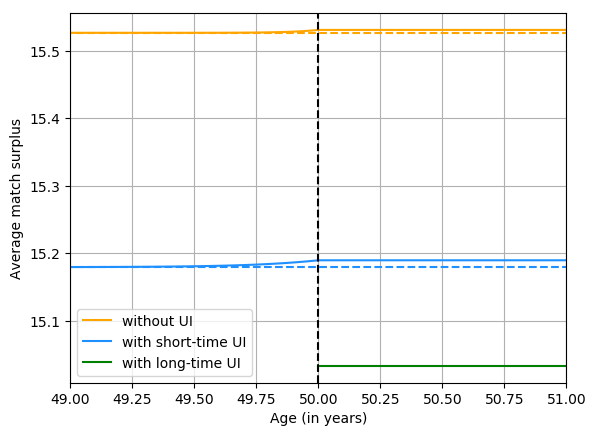

--- GRAPH DESCRIPTION ---
The blue continuous curve represents the match surplus when a worker receives UI benefits for a shorter entitlement period.
The orange continuous curve represents the match surplus when a worker only receives the social assistance.
The green curve represents the match surplus when a worker receives UI benefits for a longer entitlement period.
The dashed curves are the curves under the counterfactual situation.
-----


In [7]:
simuplot_surplus(simu_aus,austria, xaxis=[49,51]*12)

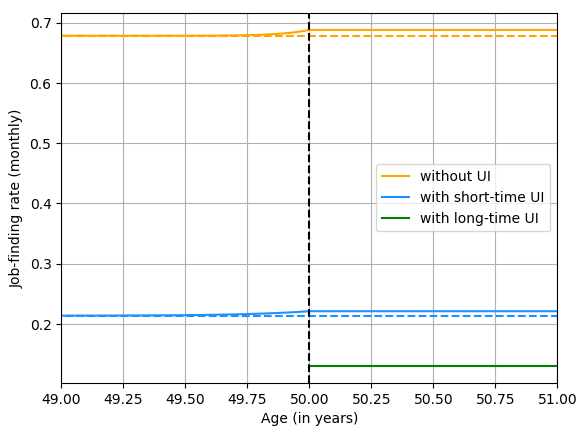

--- GRAPH DESCRIPTION ---
The blue continuous curve represents the job-finding rate when a worker receives UI benefits for a shorter entitlement period.
The orange continuous curve represents the job-finding rate when a worker only receives the social assistance.
The green curve represents the job-finding rate when a worker receives UI benefits for a longer entitlement period.
The dashed curves are the curves under the counterfactual situation.
-----


In [8]:
simuplot_JF(simu_aus,austria, xaxis=[49,51]*12)

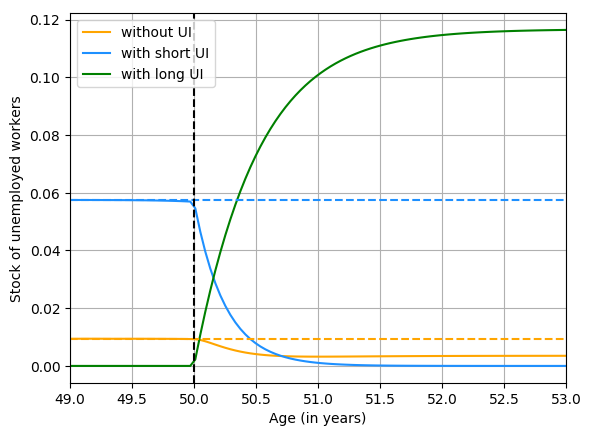

--- GRAPH DESCRIPTION ---
The blue continuous curve represents the unemployment rate with short-time UI benefits.
The orange continuous curve represents the uemplpoyment rate under the social assistance.
The green curve represents the unemployment rate with long-time UI benefits.
The dashed curves give the counterfactual dynamics without a policy change.
-----


In [9]:
unemp_aus = find_unemp(simu_aus, austria, unitSS = true) 
unemp_aus_counter0 = find_unemp_counter0(simu_aus, austria, unitSS = true) 
unemp_aus_counter1 = find_unemp_counter1(simu_aus, austria, unitSS = true) 
simuplot_unemp(unemp_aus,unemp_aus_counter0,austria, xaxis=[49.,53]*12)

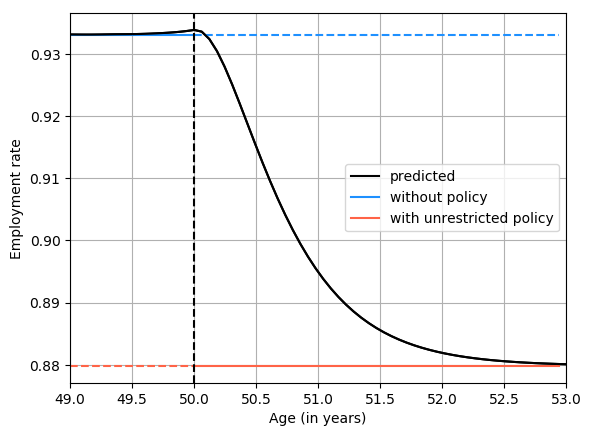

In [10]:
simuplot_emp_withpoints(unemp_aus,unemp_aus_counter0,unemp_aus_counter1,[],[], austria, xaxis=[49.,53.]*12) #, yaxis=[0.85,0.95])

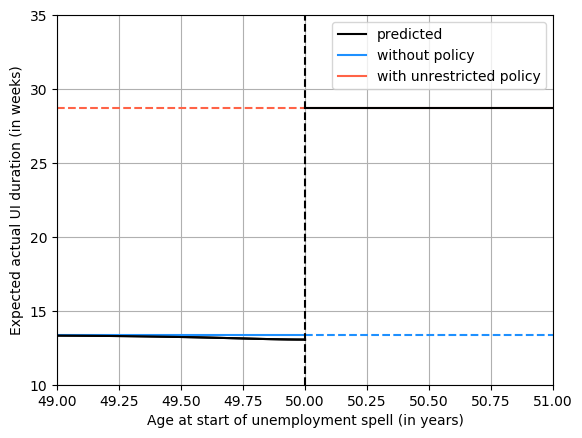

In [11]:
simuplot_B(simu_aus, austria, xaxis=[49. *12,51. *12], yaxis=[10,35], time="week")

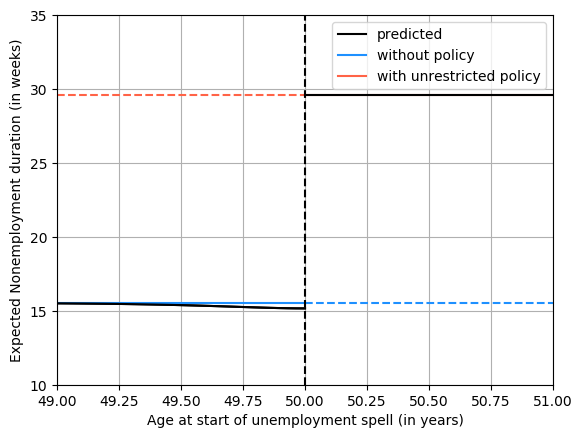

In [12]:
simuplot_D(simu_aus, austria, xaxis=[49. *12,51. *12], yaxis=[10,35], time="week")

# 3) RDD with simulated model

In [13]:
## simulated data, monthly
age_grid = 46:(1/12):54
Y = [quadSimpson(x->expectedD(x,simu_aus,austria) ,m,m+0.999999) for m in 12*age_grid] ./0.999999
#Y = [quadgk(x->expectedD(x,simu_aus,austria) ,m,m+1)[1] for m in 12*age_grid] 
#Y = [expectedD(m,simu_aus,austria) for m in 12*age_grid] 

table = zeros(3)

#explaining variables
TREAT = [a>=austria.A for a in age_grid*12]
consta = ones(size(age_grid))
age1 = collect(age_grid*12)
age2 = age1 .^2
age3 = age1 .^3
age1_spl = (age1 .- austria.A) .* TREAT 
age2_spl = (age1 .- austria.A).^2 .* TREAT 
age3_spl = (age1 .- austria.A).^3 .* TREAT 

## no trend
X = hcat(TREAT, consta)
beta = inv(X' * X) * (X' * Y)
table[1] = beta[1] 

## linear spline
X = hcat(TREAT, consta, age1, age1_spl)
beta = inv(X' * X) * (X' * Y)
table[2] = beta[1] 

## cubic spline
X = hcat(TREAT, consta, age1, age1_spl, age2, age2_spl, age3, age3_spl)
beta = inv(X' * X) * (X' * Y)
table[3] = beta[1]

table*52/12 ## multiply by 52/12 to convert in days

3-element Array{Float64,1}:
 14.107493857997524
 14.226705747366447
 14.464719399574031

In [14]:
## simulated effect of the policy 
mu0 = JFrate(simu_aus.Ybar[4],austria)
muUI = JFrate(simu_aus.Ybar[5],austria) 
lam = austria.lambdamax
expDcounter0 = ((mu0-muUI)/((lam+muUI)*(mu0-lam-muUI)) - lam/(mu0*(mu0-lam-muUI)))
expDcounter1 = expectedD(austria.Amax,simu_aus,austria)
println("The simulated model gives a LATE at ")
(expDcounter1-expDcounter0)*52/12

The simulated model gives a LATE at 


14.059624206931671

# 4) 3D Plot

In [15]:
n=400
i=0
out = zeros(n^2,3)
C=austria
for mdec in range(-1,stop=1,length=n), qdec in range(-1,stop=1,length=n)
        i +=1
        newC = Country(C.reform,C.A,C.Amin,C.Amax,C.r,C.c0,C.alpha,
                C.q*10^qdec, C.m*10^mdec,
                C.lambdamin,C.lambdamax,C.uinit,C.bUI,C.b0max,C.b0min,C.wbar)
        simu =  find_simu(newC,reltol=1e-3)
        out[i,:] = [mdec, qdec, JFrate(simu.Xbar2(C.A),newC) - JFrate(simu.Ybar[5],newC)]
end

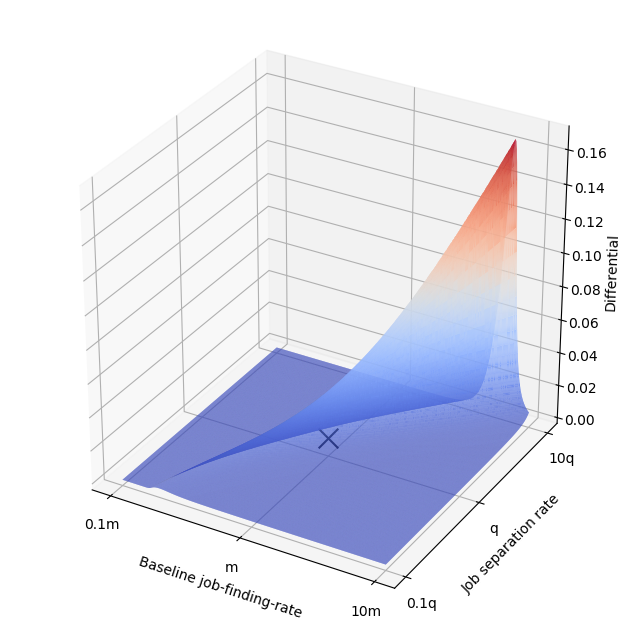

(PyCall.PyObject[PyObject <matplotlib.axis.XTick object at 0x00000000648C2C18>, PyObject <matplotlib.axis.XTick object at 0x00000000648C2E48>, PyObject <matplotlib.axis.XTick object at 0x00000000038E7438>], PyCall.PyObject[PyObject Text(0.02769256453834199, -0.08618504995699079, '0.1q'), PyObject Text(0.049392549231486886, -0.0636509500288674, 'q'), PyObject Text(0.06966705245025402, -0.04259712496930023, '10q')])

In [16]:
figure(figsize=(8,8))
surf(out[:,1],out[:,2],out[:,3], cmap = "coolwarm")
scatter3D(0, 0, JFrate(simu_aus.Xbar2(austria.A),austria)-JFrate(simu_aus.Ybar[5],austria), s=200, color="black", marker="x")
xlabel("Baseline job-finding-rate")
ylabel("Job separation rate")
zlabel("Differential")
zlim([0,0.17])
xticks([-1,0,1], ["0.1m","m","10m"])
yticks([-1,0,1], ["0.1q","q","10q"])

In [17]:
JFrate(simu_aus.Xbar2(austria.A),austria)-JFrate(simu_aus.Ybar[5],austria)

0.007459620919468418